### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('../modules')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
s3_path = 'nneehal/DATA/odata/m6_knn_no_cluster_only_latent'
data_path = '../temp'

!aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/{s3_path} {data_path} --recursive;

download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/odata/m6_knn_no_cluster_only_latent/treated0_o.p to ../temp/treated0_o.p
download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/odata/m6_knn_no_cluster_only_latent/match0_o.p to ../temp/match0_o.p
download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/odata/m6_knn_no_cluster_only_latent/random_o.p to ../temp/random_o.p


In [5]:
%%time
p = '../temp/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 178 ms, sys: 105 ms, total: 283 ms
Wall time: 300 ms


In [6]:
### Optional(filter registrations after  a particular month and before a particular month)

In [7]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [8]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}


kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [9]:
path_tabs = '../res/tabs/'
path_figs = '../res/figs/'
path_figs2 = '../res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [10]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Line of Bussiness', 'Treatment']

In [11]:
treated = treated.rename(columns={"MEDICAID_LOB":"LOB"})
controls = controls.rename(columns={"MEDICAID_LOB":"LOB"})

### Diabetes

In [12]:
%%time
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 13.7 s, sys: 49.7 ms, total: 13.8 s
Wall time: 13.8 s


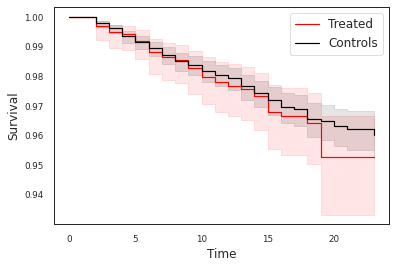

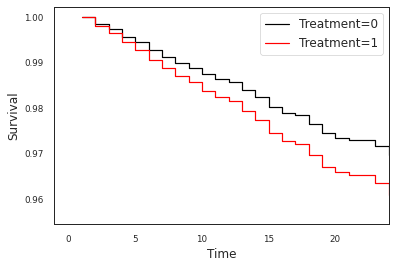

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [14]:
lrsumm

test_statistic         p  -log2(p)
Diabetes        0.438631  0.507784  0.977714

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                      2.164           0.444        4.871    0.000
Gender                   0.457           0.145        3.158    0.002
Total Cost               0.304           0.108        2.811    0.005
Tobacco use              0.059           0.294        0.199    0.842
Obesity                  0.398           0.155        2.566    0.010
Hypertension            -0.039           0.176       -0.222    0.824
Hypothyroid              0.079           0.271        0.293    0.769
Disease Count           -1.167           0.775       -1.505    0.132
Line of Bussiness       -0.769           0.206       -3.729    0.000
Treatment                0.257           0.175        1.466    0.143

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.8 s, sys: 24.8 ms, total: 13.8 s
Wall time: 13.8 s


In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'ER'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [19]:
lrsumm

test_statistic         p  -log2(p)
ER        4.165205  0.041262  4.599028

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.603           0.187       -8.567    0.000
Gender                  -0.116           0.072       -1.615    0.106
Total Cost               0.148           0.047        3.164    0.002
Tobacco use              0.359           0.101        3.534    0.000
Obesity                 -0.105           0.069       -1.531    0.126
Hypertension             0.163           0.081        2.014    0.044
Hypothyroid             -0.418           0.132       -3.163    0.002
Disease Count            2.321           0.293        7.927    0.000
Line of Bussiness       -0.830           0.080      -10.413    0.000
Treatment               -0.174           0.086       -2.031    0.042

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.7 s, sys: 27.5 ms, total: 13.8 s
Wall time: 13.8 s


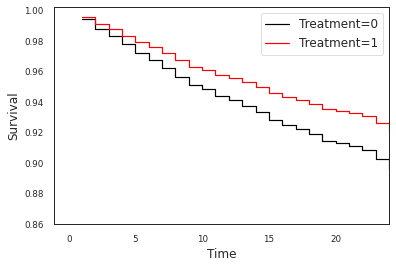

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'IP'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [24]:
ax1.collections[0].set

<bound method Artist.set of <matplotlib.collections.PolyCollection object at 0x7fb4cf623ba8>>

In [25]:
lrsumm

test_statistic         p  -log2(p)
IP        5.481141  0.019223  5.701045

In [26]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.565           0.254       -6.156    0.000
Gender                  -0.052           0.096       -0.544    0.587
Total Cost               0.401           0.073        5.530    0.000
Tobacco use              0.305           0.139        2.188    0.029
Obesity                 -0.277           0.094       -2.961    0.003
Hypertension             0.299           0.108        2.759    0.006
Hypothyroid             -0.442           0.180       -2.460    0.014
Disease Count            2.480           0.374        6.625    0.000
Line of Bussiness       -0.388           0.115       -3.359    0.001
Treatment               -0.290           0.121       -2.394    0.017

### Acute Care IP OR ER

In [27]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [28]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.8 s, sys: 26.8 ms, total: 13.8 s
Wall time: 13.8 s


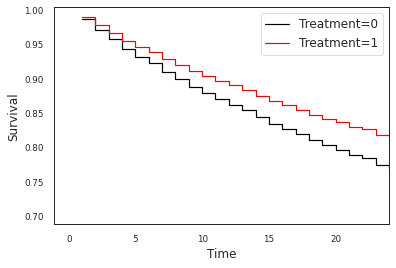

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline)

In [30]:
lrsumm

test_statistic         p  -log2(p)
Acute        9.252729  0.002351  8.732235

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.536           0.162       -9.478    0.000
Gender                  -0.094           0.061       -1.539    0.124
Total Cost               0.215           0.041        5.194    0.000
Tobacco use              0.348           0.090        3.887    0.000
Obesity                 -0.120           0.059       -2.016    0.044
Hypertension             0.250           0.069        3.616    0.000
Hypothyroid             -0.428           0.114       -3.751    0.000
Disease Count            2.280           0.254        8.975    0.000
Line of Bussiness       -0.723           0.070      -10.259    0.000
Treatment               -0.242           0.075       -3.215    0.001

### Load all Log Rank Sums in a matrix

In [32]:
from pathlib import Path
p = Path('../res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('../res/tabs/all_logrank.csv')


In [33]:
df2

logRank statistic   p-value  RMST difference
Diabetes                   0.438631  0.507784        -0.073816
Emergency Visits           4.165205  0.041262         0.399661
Inpatient Vistis           5.481141  0.019223         0.377165
Acute Care                 9.252729  0.002351         0.714898